# Exploratory data analysis HUPA-UCM Diabetes 
<br>  Morales Martinez Arturo 
<br>  Moreno Santa Maria Luis Daniel

## Preprocessed Data 

### Number of rows by patient

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import re
from tabulate import tabulate

Just to find patient's number

In [2]:
def find_number_string(string):
    numbers = re.findall(r'\d+', string)
    return numbers

The following cell is intended to get a dictionary where each key is the patient's id amd the value the number of rows 

In [3]:
data_dir = 'HUPA-UCM Diabetes Dataset/Preprocessed'
patients = {int(find_number_string(os.path.join(data_dir, filename))[0]) : pd.read_csv(os.path.join(data_dir, filename), sep=';').shape[0]
                   for filename in os.listdir(data_dir)}

### Just to sort by the amount of rows
patients = dict(sorted(patients.items(), key=lambda item: item[1]))

Now, just tabulate days, months and year per patient 

In [7]:
table = []
for key, value in patients.items():
    days = value / 288
    months = days / 30
    years = months / 12
    table.append([key, value, days, months, years])
print(tabulate(table, headers=["Patient", "Rows", "Days", "Months", "Years"], tablefmt="grid"))

+-----------+--------+-----------+-----------+-----------+
|   Patient |   Rows |      Days |    Months |     Years |
+===========+========+===========+===========+===========+
|         6 |   2290 |   7.95139 |  0.265046 | 0.0220872 |
+-----------+--------+-----------+-----------+-----------+
|        21 |   2343 |   8.13542 |  0.271181 | 0.0225984 |
+-----------+--------+-----------+-----------+-----------+
|        20 |   2862 |   9.9375  |  0.33125  | 0.0276042 |
+-----------+--------+-----------+-----------+-----------+
|        24 |   2902 |  10.0764  |  0.33588  | 0.02799   |
+-----------+--------+-----------+-----------+-----------+
|        10 |   2976 |  10.3333  |  0.344444 | 0.0287037 |
+-----------+--------+-----------+-----------+-----------+
|         2 |   3181 |  11.0451  |  0.368171 | 0.0306809 |
+-----------+--------+-----------+-----------+-----------+
|         4 |   3184 |  11.0556  |  0.368519 | 0.0307099 |
+-----------+--------+-----------+-----------+----------

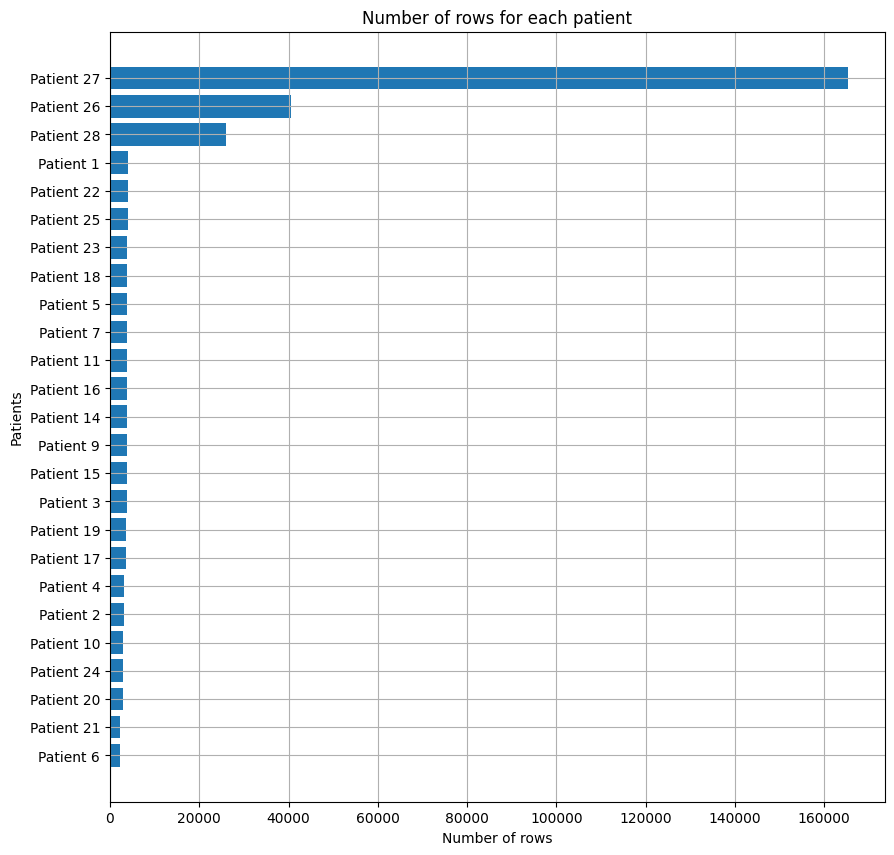

In [9]:
plt.figure(figsize=(10, 10))
plt.barh([f'Patient {key}' for key, value in patients.items()], [value for key, value in patients.items()])
plt.xlabel('Number of rows')
plt.ylabel('Patients')
plt.grid(True)
plt.title('Number of rows for each patient')
plt.savefig('Images/Number_rows_by_patient')